# Phase 2 - Data preprocessing
### Authors: Karolina Skrypova(50%), Oleh Fedunchyk(50%)

## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Loading the data

In [ ]:
connections_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/connections.csv', sep='\t')
processes_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/processes.csv', sep='\t')

## Datasets for processing

Our constants:

In [ ]:
selected_attributes = [
    "mwra",
    "p.android.externalstorage",
    "p.android.settings",
    "p.android.gm",
    "p.system",
    "p.android.packageinstaller",
    "c.android.gm",
    "c.android.youtube",
    "p.android.chrome",
    "c.android.chrome"
]

In [ ]:
def divide_df(df):
    mwra = df['mwra']
    df_ = df.drop('mwra', axis=1)
    return train_test_split(df_, mwra, test_size=0.2, random_state=42)

In [ ]:
merged_data = pd.merge(processes_data, connections_data).drop_duplicates()
train_data, test_data = train_test_split(merged_data[selected_attributes], test_size=0.25)
mwra_train = pd.DataFrame(train_data.pop('mwra'))
mwra_test = pd.DataFrame(test_data.pop('mwra'))

In [ ]:
mwra_train.head()

,mwra
12309,0.0
6191,0.0
13858,1.0
10734,1.0
2984,1.0


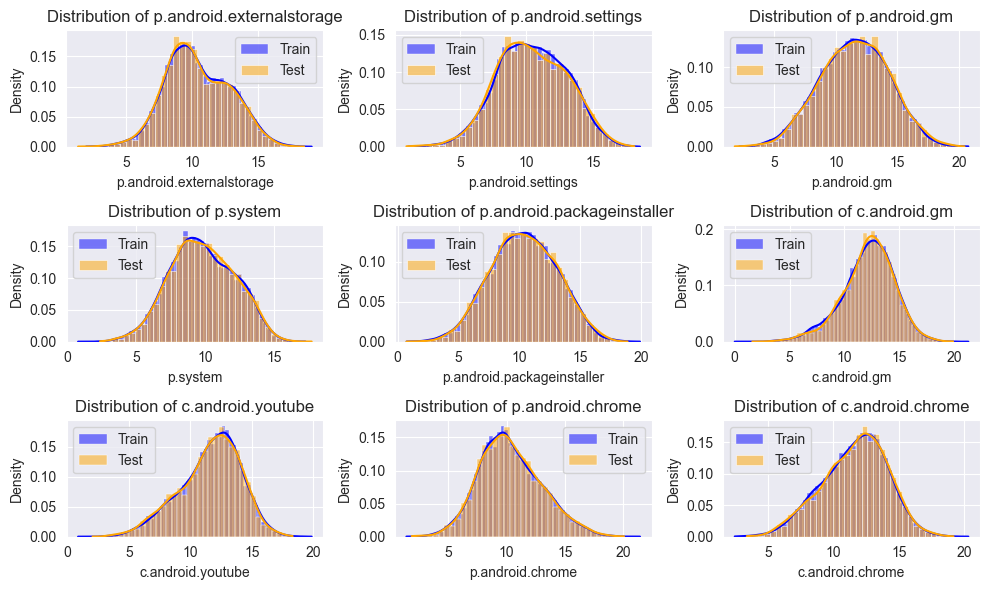

In [ ]:
num_columns = 3
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, num_rows * 2))
axes = axes.flatten()

for idx, column in enumerate(train_data.columns):
    sns.histplot(train_data[column], color='blue', label='Train', kde=True, stat="density", ax=axes[idx])
    sns.histplot(test_data[column], color='orange', label='Test', kde=True, stat="density", ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## Data pre-processing pipeline

### Data cleaning

In [ ]:
class Cleaner(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.apply(self.resolve_missing_values)
        return X_.apply(self.transform_outliers)

    # we do not have NA values in our dataset, but let this step be in our pipeline
    def resolve_missing_values(self, column):
        return column.fillna(column.median())

    # we have checked mrwa have no outliers so can also be proceeded by this function
    def transform_outliers(self, column):
      Q1 = column.quantile(0.25)
      Q3 = column.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      outliers = column[(column < lower_bound) | (column > upper_bound)]
      cleaned_column = column.clip(lower=lower_bound, upper=upper_bound)

      return cleaned_column

### Data transforming

In [ ]:
class Transformer(TransformerMixin):
    def __init__(self):
        self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

    def fit(self, X, y=None):
        self.power_transformer.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.power_transformer.transform(X), columns=X.columns)

### Data scaling

In [ ]:
class Scaler(TransformerMixin):
    def __init__(self):
        self.standard_scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.standard_scaler.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.standard_scaler.transform(X), columns=X.columns)

### Pipeline

In [ ]:
pipeline = Pipeline([
    ('cleaner', Cleaner()),
    ('transformer', Transformer()),
    ('scaler', Scaler())
]).fit(train_data, mwra_train)

In [ ]:
train_data_transformed = pipeline.transform(train_data)
test_data_transformed = pipeline.transform(test_data)

## 3.1 Simple ID3 classifier based on dependencies in the data

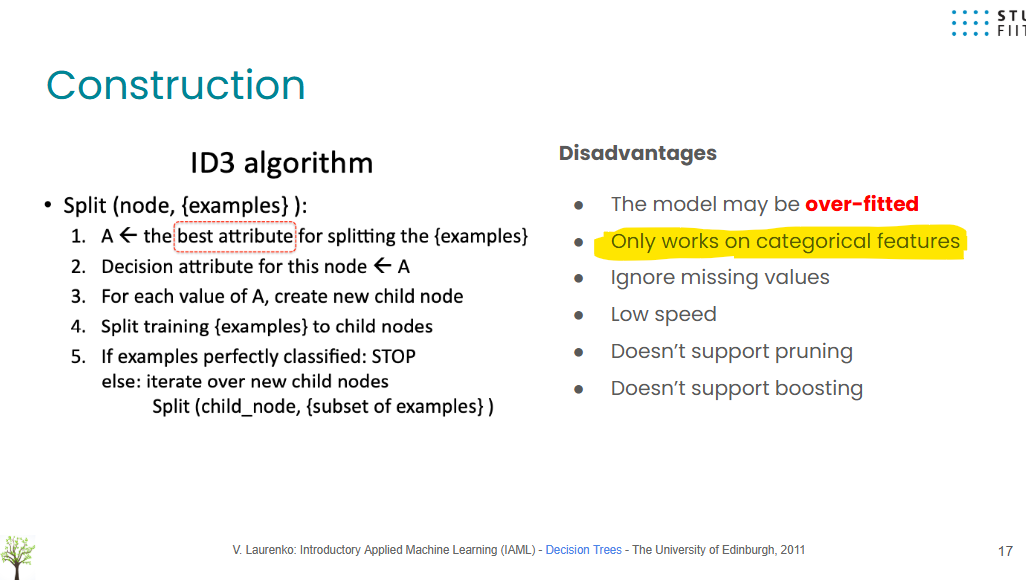

In [ ]:
class ClassifierID3(ClassifierMixin):

    class TreeNode:
        def __init__(self, dataset, depth, attribute=None, interval_lower_bound=None, interval_upper_bound=None):
            self.dataset = dataset
            self.depth = depth
            self.attribute = attribute
            self.interval_lower_bound = interval_lower_bound
            self.interval_upper_bound = interval_upper_bound
            self.children = []
            self.predicted_value = None  # only for leaf nodes

        def is_leaf(self):
            return self.predicted_value is not None


    def __init__(self, intervals_number, max_depth=None):
        if max_depth is not None and max_depth <= 2:
            raise ValueError("Min depth must be at least 2.")

        if  intervals_number <= 2:
            raise ValueError("Intervals number must be at least 2.")

        self.max_depth = max_depth
        self.intervals_number = intervals_number
        self.target_attribute = None
        self.tree = None

    def fit(self, X, y):
        # Combine the features (X) and target (y) into one DataFrame
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)

        X['index'] = X.index
        y['index'] = y.index

        # Now merge the DataFrames using the common column 'index'
        data = pd.merge(X, y, on='index')

        data = data.drop(columns=['index'])

        self.target_attribute = y.columns[0]

        # Building the tree
        root = self.TreeNode(data, 0)
        self.tree = self._build_tree(root)

        return self


    def _build_tree(self, node):

        # print("----------------------------------------------------------------------------------------")
        # print("-----  ", node.depth, "  -------")
        # print("-----  ", node.dataset.shape[0], "  -------")
        # print("-----  ", node.dataset.columns, "  -------")
        # print(node.dataset.head(10))

        # Calculate the frequency of ea(ch class label (target attribute)
        target_counts = node.dataset[self.target_attribute].value_counts()

        # print("-----  ", len(target_counts), "  -------")


        # If all labels are the same, return a leaf node
        if len(target_counts) == 1:
            node.predicted_value = target_counts.index[0]
            return node

        # If max depth is reached or dataset has 1 attribute, create a leaf node with the most frequent class
        if node.depth == self.max_depth or len(node.dataset.columns) == 1:
            node.predicted_value = target_counts.idxmax()
            return node

        # Find the best attribute to split on
        best_attribute = self._get_best_attribute_for_split(node.dataset)
        node.attribute = best_attribute
        # print(best_attribute)

        # Split the data based on the chosen attribute into intervals
        intervals = self._get_intervals(node.dataset[best_attribute])

        # creating children
        interval_lower_bound = intervals[0]
        for interval_upper_bound in intervals[1:]:
            # Create a child node for the current interval
            child_data = self._get_dataset_in_interval(node.dataset, best_attribute, interval_lower_bound, interval_upper_bound).drop(best_attribute, axis=1)

            if not child_data.empty:
                child_node = self.TreeNode(dataset=child_data, depth=node.depth + 1, interval_lower_bound=interval_lower_bound, interval_upper_bound=interval_upper_bound)
                node.children.append(child_node)

            interval_lower_bound = interval_upper_bound

        # recursion
        for child in node.children:
            self._build_tree(child)

        return node


    def _get_best_attribute_for_split(self, dataset):
        """
        Calculate the Information Gain for all attributes and return the best one.
        """
        best_info_gain = -np.inf
        best_attribute = None

        # Check each feature (excluding the target attribute)
        for attribute in dataset.columns:
            if attribute != self.target_attribute:
                info_gain = self._information_gain(dataset, attribute)
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_attribute = attribute

        return best_attribute

    def _information_gain(self, dataset, attribute):
        """
        Calculate the information gain from splitting on an attribute.
        """
        # print("----------------------------------------------------------------------------------------")
        # print("-----  ", attribute, "  -------")

        entropy_before = self._entropy(dataset)

        # print("----------------------------------------------------------------------------------------")


        # Get the unique values for the attribute and split the data
        splits = self._split_data_by_attribute(dataset, attribute)
        total_count = len(dataset)

        weighted_entropy = 0.0
        for split in splits:
            weighted_entropy += (len(split) / total_count) * self._entropy(split)

        return entropy_before - weighted_entropy

    def _entropy(self, dataset):
        """
        Calculate the entropy of the target attribute.
        """
        # print(dataset.head(4))

        class_counts = dataset[self.target_attribute].value_counts()
        total_count = len(dataset)
        entropy = 0.0

        for count in class_counts:
            probability = count / total_count
            entropy -= probability * np.log2(probability)

        return entropy


    def _split_data_by_attribute(self, dataset, attribute):
        """
        Split the dataset by the attribute value intervals.
        """
        splits = []

        # Split the data based on the chosen attribute into intervals
        intervals = self._get_intervals(dataset[attribute])

        interval_lower_bound = intervals[0]
        for interval_upper_bound in intervals[1:]:
            splits.append(self._get_dataset_in_interval(dataset, attribute, interval_lower_bound, interval_upper_bound))
            interval_lower_bound = interval_upper_bound

        return splits

    def _get_intervals(self, attribute_values):
        """
        Create intervals based on the attribute values.
        Discretize continuous values into intervals.
        """
        min_value, max_value = attribute_values.min(), attribute_values.max()
        interval_size = (max_value - min_value) / self.intervals_number

        intervals = [min_value + i * interval_size for i in range(self.intervals_number + 1)]
        return intervals

    def _get_dataset_in_interval(self, dataset, attribute, lower_bound, upper_bound):
        """
        Return the subset of the dataset where the attribute values fall within the given interval.
        """
        return dataset[(dataset[attribute] >= lower_bound) & (dataset[attribute] < upper_bound)]




    def predict(self, X):
        """
        Predict the class for a new sample using the trained tree.
        """
        # return X.apply(self._predict_sample, axis=1)
        predictions = []
        # counter = 0
        for index, row in X.iterrows():
            # print("----------------------------------------------------------------------------------------")
            # counter += 1
            # print(counter)
            prediction = self._predict_sample(row)
            predictions.append(prediction)


        return predictions

    def _predict_sample(self, sample):
        """
        Predict the class label for a single sample.
        """
        # print("sample: ", sample)

        node = self.tree

        way = []

        while not node.is_leaf():
            value = sample[node.attribute]
            # print("att: ", node.attribute)
            # print("val:", value)
            # print("ch: ", len(node.children))
            # print("---------")

            way.append(node.attribute)

            smallest_interval_node = node.children[0]
            biggest_interval_node = node.children[0]

            for child in node.children:
                # print(child.interval_lower_bound)
                # print(child.interval_upper_bound)
                # print("---------")

                if child.interval_lower_bound <= value < child.interval_upper_bound:
                    node = child
                    break

                if child.interval_lower_bound < smallest_interval_node.interval_lower_bound:
                    smallest_interval_node = child
                if child.interval_upper_bound > biggest_interval_node.interval_upper_bound:
                    biggest_interval_node = child

            # If no matching interval found, assign to closest bound
            else:
                if value < smallest_interval_node.interval_lower_bound:
                    # Assign to lowest interval
                    node = smallest_interval_node
                else:
                    # Assign to highest interval
                    node = biggest_interval_node


        # print(node.predicted_value)
        return node.predicted_value

In [ ]:
classifier = ClassifierID3(intervals_number=5)
classifier.fit(train_data_transformed, mwra_train)

In [ ]:
#Make predictions using the transformed data
y_pred = classifier.predict(test_data_transformed)

# Evaluate the classifier
accuracy = accuracy_score(mwra_test, y_pred)
precision = precision_score(mwra_test, y_pred, average='binary')
recall = recall_score(mwra_test, y_pred, average='binary')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Check for overfitting
train_pred = classifier.predict(train_data_transformed)  # Use transformed data for training prediction
train_accuracy = accuracy_score(mwra_train, train_pred)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy}")

Accuracy: 0.8404596472474613
Precision: 0.8852106620808254
Recall: 0.8618668899120971
Train Accuracy: 0.946449255992159
Test Accuracy: 0.8404596472474613
